# 2.4 Evaluating Hyperparameters

## Contents:

1. Import Libraries
2. Import Datasets
3. Data Wrangling
4. Reshaping the Model
5. Data Split
6. Hyperparameter Optimisation - Grid Search
7. Random Search
8. Running Random Forest with Optimised Search Parameters
9. Uncovering Feature Importances

## 1. Import Libraries

In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## 2. Import Datasets

In [286]:
# Define path to dataset
path = r'/Users/analazarevska/Documents/CAREER FOUNDRY/Data Analytics Program/Machine Learning/A1, Basics of Machine Learning for Analysts/ClimateWins/'

# Import dataset
df = pd.read_csv(os.path.join(path, 'Data Sets', 'df_cleaned_with_date.csv'))
df_pleasant = pd.read_csv(os.path.join(path, 'Data Sets', 'df_pleasant_with_date.csv'))

In [287]:
df.shape

(22950, 137)

In [288]:
df_pleasant.shape

(22950, 16)

## 3. Data Wrangling

In [290]:
# Reduce data to one decade (2010s)
df_2010s = df.loc[df['DATE'].astype(str).str[:3] == '201']
df_pleasant_2010s = df_pleasant.loc[df_pleasant['DATE'].astype(str).str[:3] == '201']

In [291]:
# Drop date unnecessary columns

df_2010s = df_2010s.drop(['DATE', 'MONTH'], axis=1)
df_pleasant_2010s = df_pleasant_2010s.drop(columns = 'DATE')

In [292]:
df_2010s.shape

(3652, 135)

In [293]:
df_pleasant_2010s.shape

(3652, 15)

## 4. Reshaping the Model

In [295]:
# Extract unique station names from column names
stations = [col.split('_')[0] for col in df_2010s.columns if '_' in col]

# Create a set of unique station names
unique_stations = set(stations)
unique_stations

# Create a dictionary to store the frequency of entries for each station
station_frequencies = {}

for station in unique_stations:
    # Select columns that belong to the current station
    station_columns = [col for col in  df_2010s.columns if col.startswith(station)]
    
    # Count non-missing entries across all columns for the station
    station_frequencies[station] =  df_2010s[station_columns].notna().sum().sum()

# Print the frequency of entries for each station
print("Number of entries per station:")
for station, freq in station_frequencies.items():
    print(f"{station}: {freq} entries")

Number of entries per station:
MAASTRICHT: 32868 entries
BELGRADE: 32868 entries
DEBILT: 32868 entries
LJUBLJANA: 32868 entries
DUSSELDORF: 32868 entries
MUNCHENB: 32868 entries
KASSEL: 32868 entries
MADRID: 32868 entries
SONNBLICK: 32868 entries
BASEL: 32868 entries
OSLO: 32868 entries
HEATHROW: 32868 entries
VALENTIA: 32868 entries
BUDAPEST: 32868 entries
STOCKHOLM: 32868 entries


In [296]:
X = df_2010s

In [297]:
y = df_pleasant_2010s

In [298]:
# Turn X and y from a df to arrays

X = np.array(X)
y = np.array(y)

In [299]:
X.shape

(3652, 135)

In [300]:
y.shape

(3652, 15)

## 5. Data Split

In [302]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [303]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739, 15)
(913, 135) (913, 15)


## 6. Hyperparameter Optimisation - Grid Search

In [305]:
# Create a RF classifier
clf = RandomForestClassifier()  

In [306]:
# Grid search cv
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[15, 50, 100, 135], 
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

In [307]:
start = time.time()
grid = GridSearchCV(clf, param_grid=grid_space, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(X_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Search took 10.136754631996155 minutes


In [308]:
# Print grid search results

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best GRID search score is: 0.6443957648776926


## 7. Random Search

In [310]:
# Define random search cv

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(15, 135),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [311]:
# Create a RF classifier

clf2= RandomForestClassifier()

In [312]:
start = time.time()
rf_random = RandomizedSearchCV(clf2, rs_space, n_iter=10, scoring='accuracy', verbose=3, n_jobs=-1, cv=3)
model_random = rf_random.fit(X_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Search took 1.4394136985143027 minutes


In [313]:
# Random random search results

print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'gini', 'max_depth': 60, 'max_features': 97, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 60}
Best RANDOM search score is: 0.6356334428623586


In [314]:
# Grid search results vs.

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

# Random random search results

print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best GRID search score is: 0.6443957648776926
Best RANDOM search hyperparameters are: {'criterion': 'gini', 'max_depth': 60, 'max_features': 97, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 60}
Best RANDOM search score is: 0.6356334428623586


## 8. Running Random Forest with Optimised Search Parameters

In [316]:
# Create a RF classifier with the best results from above
clf3 = RandomForestClassifier(n_estimators = 200, max_depth=None, max_features=50, min_samples_leaf=1, min_samples_split=2)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf3.fit(X_train, y_train)

RandomForestClassifier(max_features=50, n_estimators=200)

In [317]:
# Perform predictions on the test dataset
y_pred = clf3.predict(X_test)
  
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.6637458926615553


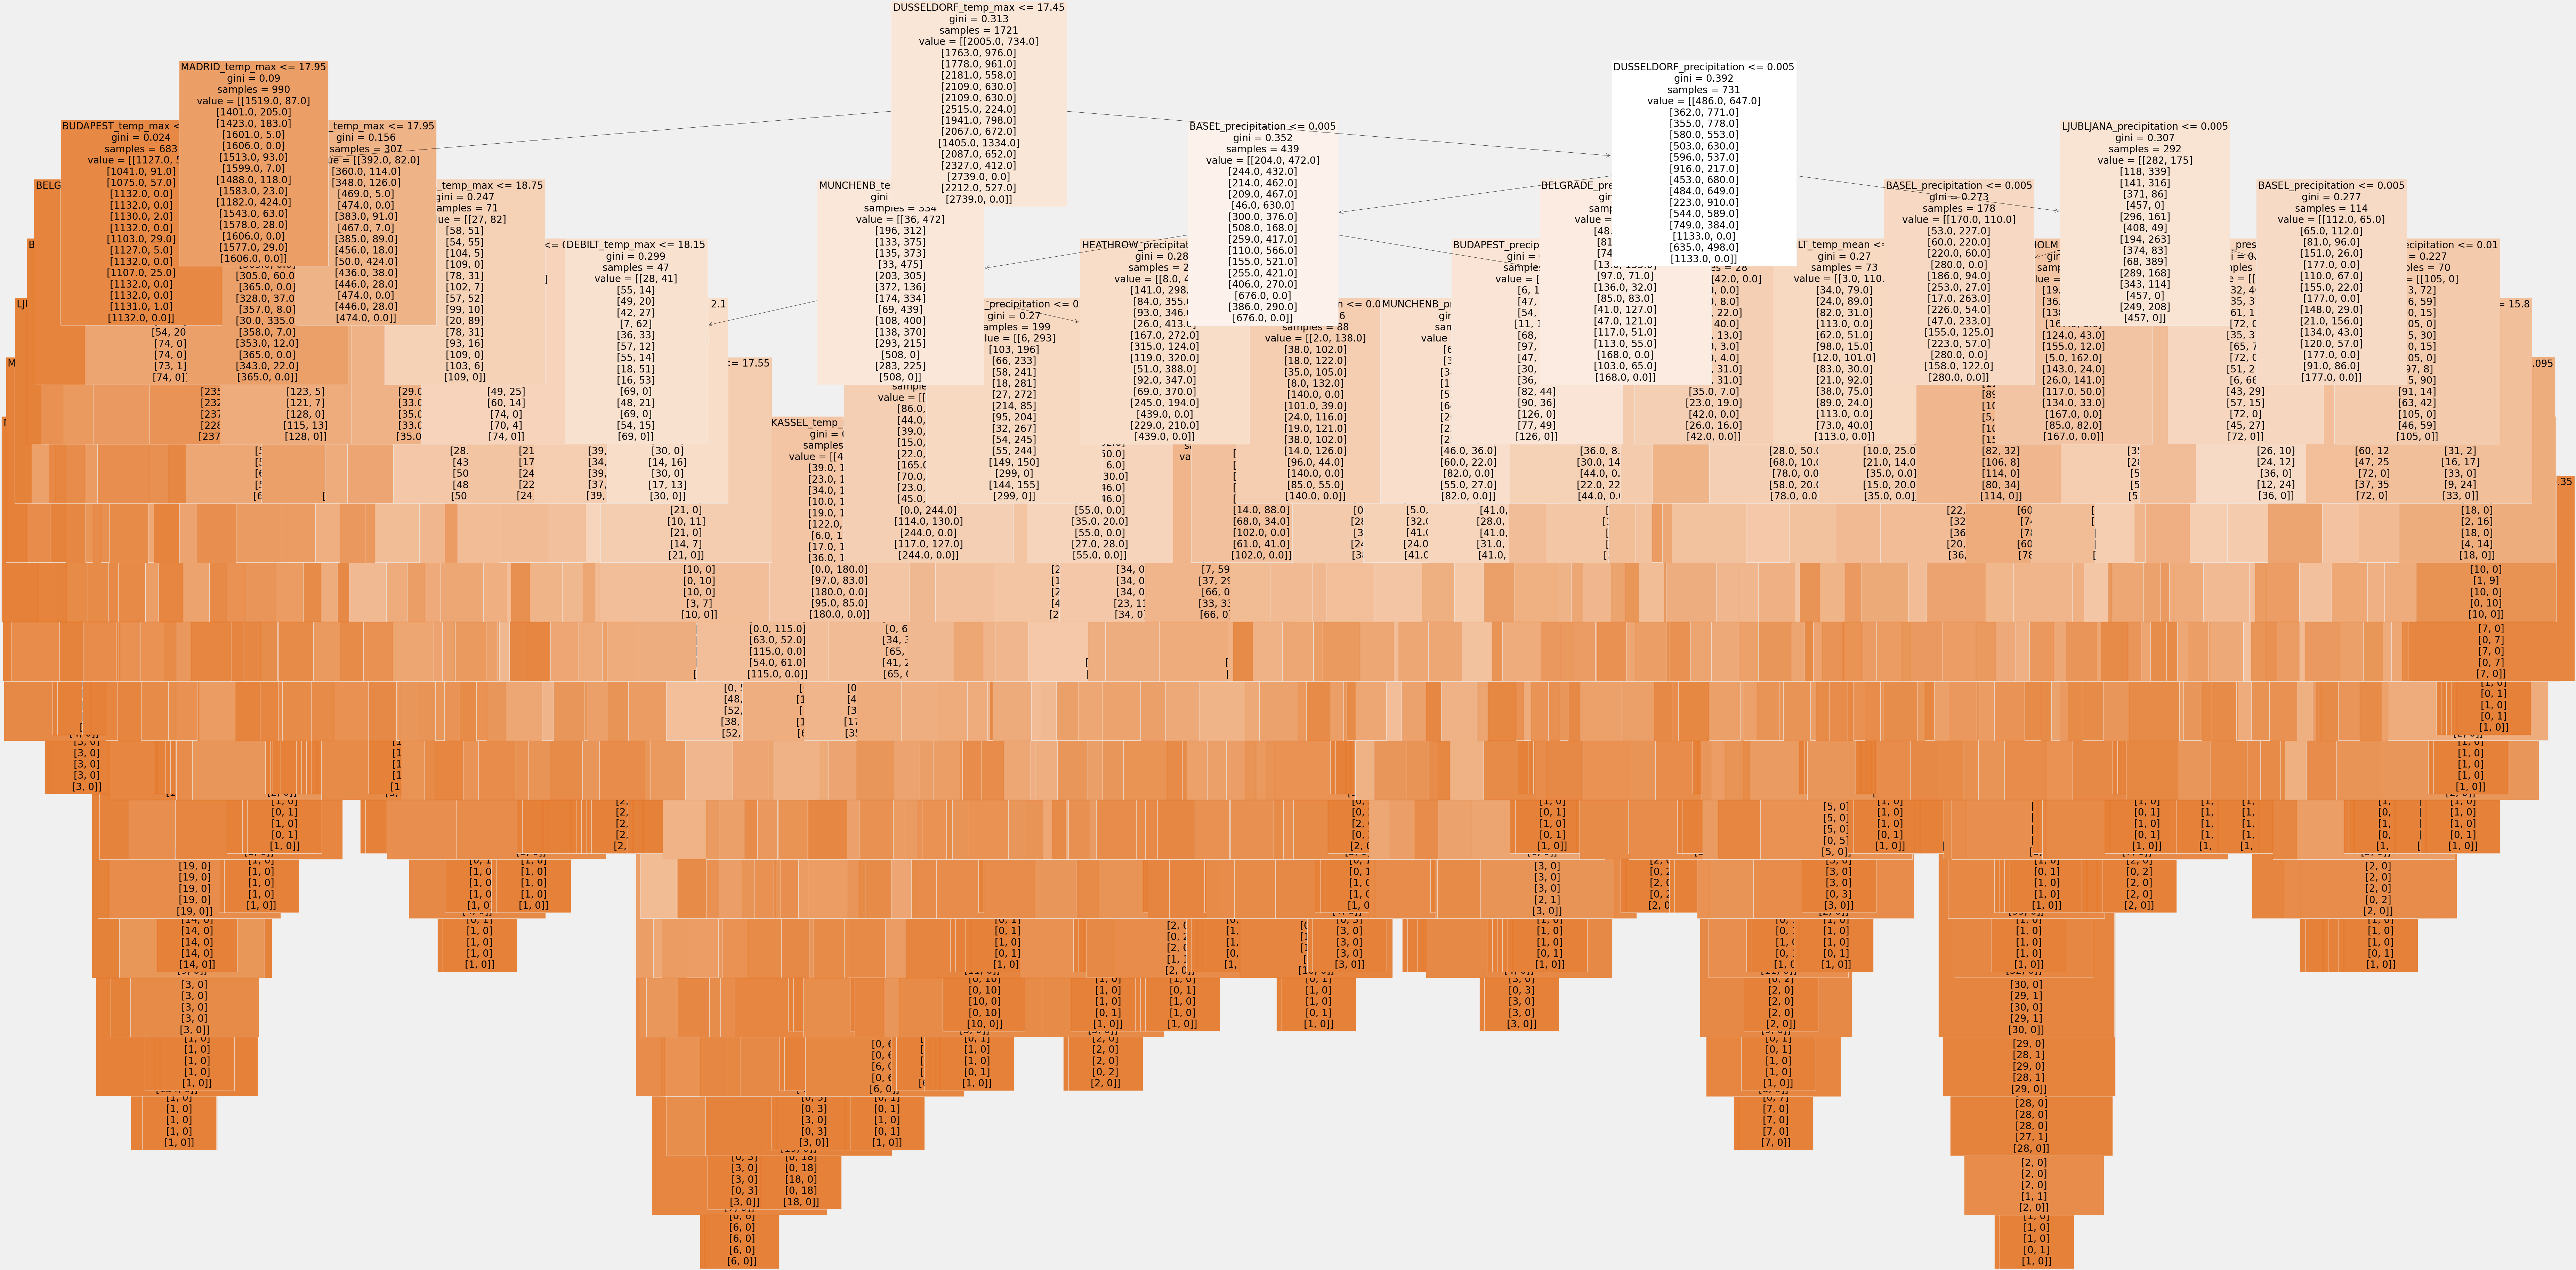

In [318]:
fig = plt.figure(figsize=(80,40))
plot_tree(clf3.estimators_[15], fontsize = 20, feature_names = df_2010s.columns, class_names=['unpleasant', 'pleasant'], filled=True);

In [319]:
fig.savefig(os.path.join(path, 'Visualisations', 'optimised_random_forest_2010s.png'),bbox_inches='tight')

## 9. Uncovering Feature Importances

In [321]:
# Retrieve feature importances from the trained model

newarray = clf3.feature_importances_
print(clf3.feature_importances_.shape)
newarray

(135,)


array([1.57483239e-03, 2.56623778e-03, 2.23099002e-03, 2.05305363e-03,
       2.83300191e-02, 4.60657487e-03, 1.15380959e-02, 1.96046398e-03,
       7.90218877e-02, 2.89343434e-03, 2.45535567e-03, 2.38383823e-03,
       2.03420055e-03, 2.62957935e-02, 2.21532779e-03, 3.80797452e-03,
       2.09859573e-03, 8.16175763e-03, 2.44642845e-04, 0.00000000e+00,
       0.00000000e+00, 8.20927108e-04, 2.52644951e-02, 9.25436330e-04,
       9.99208929e-03, 2.12279427e-03, 2.02530361e-02, 1.39786950e-03,
       2.01678407e-03, 2.49347145e-03, 2.40771605e-03, 1.97045375e-02,
       2.57608439e-03, 2.45014112e-03, 2.16742216e-03, 3.55491637e-02,
       1.46752602e-03, 1.84387094e-03, 2.39048537e-03, 2.01197483e-03,
       3.61983209e-02, 3.08111762e-03, 6.71665298e-03, 1.97646501e-03,
       1.18164911e-01, 1.89762937e-03, 3.20665011e-03, 2.51625310e-03,
       3.17723430e-03, 1.43523290e-02, 3.81560961e-03, 3.01963855e-03,
       2.10176989e-03, 9.32534809e-03, 1.87145224e-03, 1.85429055e-03,
      

In [322]:
# Reshape newarray

newarray = newarray.reshape(-1,15,9)
print(newarray.shape)
newarray

(1, 15, 9)


array([[[1.57483239e-03, 2.56623778e-03, 2.23099002e-03, 2.05305363e-03,
         2.83300191e-02, 4.60657487e-03, 1.15380959e-02, 1.96046398e-03,
         7.90218877e-02],
        [2.89343434e-03, 2.45535567e-03, 2.38383823e-03, 2.03420055e-03,
         2.62957935e-02, 2.21532779e-03, 3.80797452e-03, 2.09859573e-03,
         8.16175763e-03],
        [2.44642845e-04, 0.00000000e+00, 0.00000000e+00, 8.20927108e-04,
         2.52644951e-02, 9.25436330e-04, 9.99208929e-03, 2.12279427e-03,
         2.02530361e-02],
        [1.39786950e-03, 2.01678407e-03, 2.49347145e-03, 2.40771605e-03,
         1.97045375e-02, 2.57608439e-03, 2.45014112e-03, 2.16742216e-03,
         3.55491637e-02],
        [1.46752602e-03, 1.84387094e-03, 2.39048537e-03, 2.01197483e-03,
         3.61983209e-02, 3.08111762e-03, 6.71665298e-03, 1.97646501e-03,
         1.18164911e-01],
        [1.89762937e-03, 3.20665011e-03, 2.51625310e-03, 3.17723430e-03,
         1.43523290e-02, 3.81560961e-03, 3.01963855e-03, 2.10176989

In [323]:
# Collapse this shape into one observation for each weather station

sumarray = np.sum(newarray[0], axis=1)
sumarray

array([0.13388216, 0.05234628, 0.05962342, 0.07076319, 0.17385132,
       0.04341246, 0.02704864, 0.06912257, 0.12374127, 0.07448406,
       0.06945618, 0.04307084, 0.01864788, 0.03749747, 0.00305225])

In [324]:
# Extract stations list

stations = [col.split('_')[0] for col in df_2010s.columns if '_' in col]

In [325]:
# Create a set of unique station names

unique_stations = set(stations)
unique_stations

{'BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA'}

In [326]:
# Convert the set of unique stations to a list

unique_stations_list = list(unique_stations)

In [327]:
important = pd.Series(sumarray, index = unique_stations_list)
important = important.sort_values(ascending = False)
important

DUSSELDORF    0.173851
MAASTRICHT    0.133882
SONNBLICK     0.123741
BASEL         0.074484
LJUBLJANA     0.070763
OSLO          0.069456
MADRID        0.069123
DEBILT        0.059623
BELGRADE      0.052346
MUNCHENB      0.043412
HEATHROW      0.043071
BUDAPEST      0.037497
KASSEL        0.027049
VALENTIA      0.018648
STOCKHOLM     0.003052
dtype: float64

In [328]:
# Create a df to associate weather stations with their importances

df_importance = pd.DataFrame({
    'Weather Station': unique_stations_list,
    'Importance': sumarray
})

df_importance = df_importance.sort_values(by='Importance', ascending = False)

['MAASTRICHT', 'BELGRADE', 'DEBILT', 'LJUBLJANA', 'DUSSELDORF', 'MUNCHENB', 'KASSEL', 'MADRID', 'SONNBLICK', 'BASEL', 'OSLO', 'HEATHROW', 'VALENTIA', 'BUDAPEST', 'STOCKHOLM']


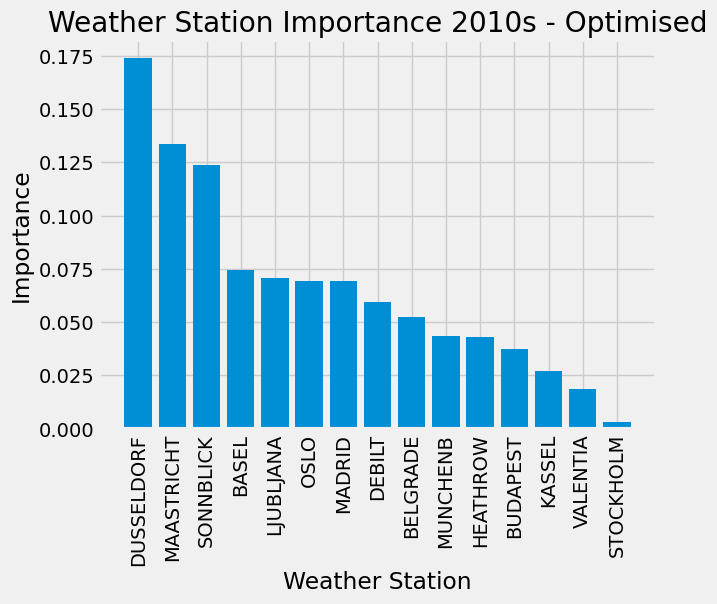

In [329]:
# Plot the results

%matplotlib inline

plt.style.use('fivethirtyeight')
print(unique_stations_list)

plt.bar(df_importance['Weather Station'], df_importance['Importance'], orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.xlabel('Weather Station')
plt.ylabel('Importance')
plt.title('Weather Station Importance 2010s - Optimised')

plt.savefig(os.path.join(path, 'Visualisations', 'optimised_2010s_feauture_importances.png'), bbox_inches='tight')

plt.show()